## 59단계: RNN을 활용한 시계열 데이터 처리

> .

### 59.1 RNN 계층 구현

<img src="images/그림 59-1.png" width=250/>
<br/>
<img src="images/식 59.1.png" width=400/>

In [1]:
# dezero/layers.py
from dezero import Layer
from dezero.layers import Linear
import dezero.functions as F

class RNN(Layer):
    def __init__(self, hidden_size, in_size=None):
        super().__init__()
        self.x2h = Linear(hidden_size, in_size=in_size)
        self.h2h = Linear(hidden_size, in_size=in_size, nobias=True)
        self.h = None
    
    def reset_state(self):
        self.h = None
        
    def forward(self, x):
        if self.h is None:
            h_new = F.tanh(self.x2h(x))
        else:
            h_new = F.tanh(self.x2h(x) + self.h2h(self.h))
        self.h = h_new
        return h_new

이제 RNN을 실행해보자

In [2]:
import numpy as np
import dezero.layers as L

rnn = L.RNN(10)
x = np.random.rand(1, 1)
h = rnn(x)
print(h.shape)

(1, 10)


최초 실행 시 계산 그래프는 다음과 같다

<img src="images/그림 59-2.png" width=400/>

데이터를 계속 주면 다음과 같이 연결된다

<img src="images/그림 59-3.png" width=600/>

### 59.2 RNN 모델 구현

In [3]:
from dezero import Model
import dezero.functions as F
import dezero.layers as L

class SimpleRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn = L.RNN(hidden_size)
        self.fc = L.Linear(out_size)
        
    def reset_state(self):
        self.rnn.reset_state()
        
    def forward(self, x):
        h = self.rnn(x)
        y = self.fc(h)
        return y


seq_data = [np.random.randn(1, 1) for _ in range(1000)]  # dummy
xs = seq_data[0:-1]
ts = seq_data[1:]

model = SimpleRNN(10, 1)
loss, cnt = 0, 0
for x, t in zip(xs, ts):
    y = model(x)
    loss += F.mean_squared_error(y, t)
    
    cnt += 1
    if cnt == 2:
        model.cleargrads()
        loss.backward()
        break

<img src="images/그림 59-4.png" width=600/>

이와 같이 일련의 입력 데이터로 구성된 계산 그래프에서의 역전파를 BPTT(Backpropagation Through Time)라고 한다.

그러나 역전파가 잘 되려면 계산 그래프를 적당한 길이에서 끊어주면 좋다.

이를 Truncated BPTT라고 한다.

### 59.3 '연결'을 끊어주는 메서드

In [4]:
# dezero/core.py

class Variable:
    ...
    
    def unchain(self):
        self.creator = None
    ...
    
    def unchain_backward(self):
        if self.creator is not None:
            funcs = [self.creator]
            while funcs:
                f = funcs.pop()
                for x in f.inputs:
                    if x.creator is not None:
                        funcs.append(x.creator)
                        x.unchain()

### 59.4 사인파 예측

999
(array([-0.0286856]), array([-0.03266713]))
(array([-0.03266713]), array([-0.03359359]))
(array([-0.03359359]), array([-0.02910069]))


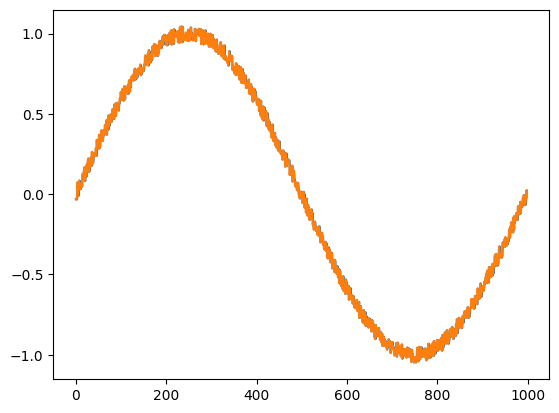

In [5]:
import numpy as np
import dezero
import matplotlib.pyplot as plt

train_set = dezero.datasets.SinCurve(train=True)
print(len(train_set))
print(train_set[0])
print(train_set[1])
print(train_set[2])

# 그래프 그리기
xs = [example[0] for example in train_set]
ts = [example[1] for example in train_set]
plt.plot(xs, label='xs')
plt.plot(ts, label='ts')
plt.show()

In [6]:
# 하이퍼파라미터 설정
max_epoch = 100
hidden_size = 100
bptt_length = 30  # BPTT 길이
train_set = dezero.datasets.SinCurve(train=True)
seqlen = len(train_set)

model = SimpleRNN(hidden_size, 1)
optimizer = dezero.optimizers.Adam().setup(model)

# 학습 시작
for epoch in range(max_epoch):
    model.reset_state()
    loss, count = 0, 0

    for x, t in train_set:
        x = x.reshape(1, 1)
        y = model(x)
        loss += F.mean_squared_error(y, t)
        count += 1
        
        # Truncated BPTT 타이밍 조정
        if count % bptt_length == 0 or count == seqlen:
            model.cleargrads()
            loss.backward()
            loss.unchain_backward()  # 연결 끊기
            optimizer.update()

    avg_loss = float(loss.data) / count
    print('| epoch %d | loss %f' % (epoch + 1, avg_loss))

| epoch 1 | loss 0.267486
| epoch 2 | loss 0.067445
| epoch 3 | loss 0.037430
| epoch 4 | loss 0.017640
| epoch 5 | loss 0.008722
| epoch 6 | loss 0.006379
| epoch 7 | loss 0.003455
| epoch 8 | loss 0.004863
| epoch 9 | loss 0.003078
| epoch 10 | loss 0.004149
| epoch 11 | loss 0.003236
| epoch 12 | loss 0.004332
| epoch 13 | loss 0.005054
| epoch 14 | loss 0.005924
| epoch 15 | loss 0.006404
| epoch 16 | loss 0.006325
| epoch 17 | loss 0.006089
| epoch 18 | loss 0.005937
| epoch 19 | loss 0.005761
| epoch 20 | loss 0.005515
| epoch 21 | loss 0.005365
| epoch 22 | loss 0.005396
| epoch 23 | loss 0.005511
| epoch 24 | loss 0.005590
| epoch 25 | loss 0.005633
| epoch 26 | loss 0.005722
| epoch 27 | loss 0.005918
| epoch 28 | loss 0.006265
| epoch 29 | loss 0.006817
| epoch 30 | loss 0.007641
| epoch 31 | loss 0.008880
| epoch 32 | loss 0.010580
| epoch 33 | loss 0.013231
| epoch 34 | loss 0.013308
| epoch 35 | loss 0.012438
| epoch 36 | loss 0.018635
| epoch 37 | loss 0.010724
| epoch 38

/tmp/ipykernel_59381/3134256770.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_list.append(float(y.data))


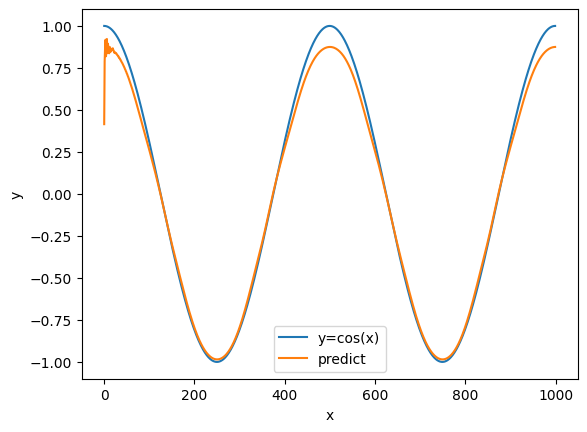

In [7]:
import matplotlib.pyplot as plt

xs = np.cos(np.linspace(0, 4 * np.pi, 1000))
model.reset_state()
pred_list = []

with dezero.no_grad():
    for x in xs:
        x = np.array(x).reshape(1, 1)
        y = model(x)
        pred_list.append(float(y.data))

plt.plot(xs, label='y=cos(x)')
plt.plot(pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

현재는 배치 크기가 1이라 시간이 오래 걸린다. 다음 단계에서는 미니배치 단위로 처리해보자.